# Analyzing My Resting Heartrate
## Time Series Analysis

I exported my own HeartWatch app data from the last year to see if I could identify any seasons or trends and predict my future resting heart rate if I maintain the same lifestyle.

I use 4 different models to determine which will be the most accurate (lowest MAE) with this data and visualize the results.
- XGBOOST, Fb Prophet, SARIMAX, and NN (Neural Networks)

- /content/drive/MyDrive/Colab_projects/data/HeartWatch-20221010-to-20231010.csv

# Citation

### Code and Workflow
Tawfik Abbas, Sherif A. Compare time series predictions of COVID-19 deaths. Coursera. https://www.coursera.org/learn/compare-time-series-predictions-of-covid19-deaths

### Data
The data is my own.

# Install and Import libraries

In [74]:
!pip install pmdarima

In [75]:
!pip install prophet

In [76]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')

# Explore and Prepare the Data

In [77]:
path = '/content/drive/MyDrive/Colab_projects/data/HeartWatch-20221010-to-20231010.csv'
health_df = pd.read_csv(path)

health_df.head()

,ISO,Date,Time Asleep,Sleep-bpm,Sleep-lo-bpm,Sleep-hi-bpm,Sleep-HRV-ms,Waking-bpm,Waking-HRV-ms,Daily-Avg.-bpm,...,Workout-%,Workout-hi-bpm,Workout-hi-%,2min Recovery-bpm,Workout-Cals,Workout-Load,Workout-mi.,Weight-lbs,Waist-in,Fat-%
0,2022-10-12T04:00:00-05:00,"Wednesday, Oct 12",07:32:00,66.1,55.0,80.0,37.0,56,71,76.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-13T04:00:00-05:00,"Thursday, Oct 13",06:45:00,66.2,58.0,84.0,46.0,58,63,73.4,...,50.6,104.0,55.9,NaN,84.0,NaN,1.58,NaN,NaN,NaN
2,2022-10-14T04:00:00-05:00,"Friday, Oct 14",06:01:00,67.9,56.0,75.0,58.0,59,131,77.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-15T04:00:00-05:00,"Saturday, Oct 15",09:09:00,65.6,56.0,78.0,36.0,53,119,79.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-16T04:00:00-05:00,"Sunday, Oct 16",06:50:00,63.5,51.0,79.0,55.0,55,77,75.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# Checking all my options for analysis by printing the columns
# I will select: ISO, Sed-Avg.-bpm
health_df.columns

Index(['ISO', 'Date', 'Time Asleep', 'Sleep-bpm', 'Sleep-lo-bpm',
       'Sleep-hi-bpm', 'Sleep-HRV-ms', 'Waking-bpm', 'Waking-HRV-ms',
       'Daily-Avg.-bpm', 'Daily-lo-bpm', 'Daily-hi-bpm', 'Sed-Avg.-bpm',
       'Sed-lo-bpm', 'Sed-<50bpm-%', 'Sed-hi-bpm', 'Sed->100bpm-%',
       'BP (am)-Sys', 'BP (am)-Dia', 'BP (pm)-Sys', 'BP (pm)-Dia',
       'Temperature-°', 'Daily SpO2-%', 'Sleep SpO2-%', 'Waking Glucose-',
       'Daily Glucose-', 'Daily Glucose-lo', 'Daily Glucose-hi', 'Move-Cals',
       'Steps', 'Distance-mi.', 'Workout-mins', 'Workout-bpm', 'Workout-%',
       'Workout-hi-bpm', 'Workout-hi-%', '2min Recovery-bpm', 'Workout-Cals',
       'Workout-Load', 'Workout-mi.', 'Weight-lbs', 'Waist-in', 'Fat-%'],
      dtype='object')

In [79]:
# Select those columns and save them in a new dataframe
d = health_df.filter(['ISO', 'Sed-Avg.-bpm'], axis=1)

d.rename(columns={'ISO': 'Date'}, inplace=True)
d.rename(columns={'Sed-Avg.-bpm': 'Resting_BPM'}, inplace=True)

# Convert ISO format to just the date
d['Date'] = d['Date'].str.slice(0, 10)

d.head()

,Date,Resting_BPM
0,2022-10-12,75.9
1,2022-10-13,72.1
2,2022-10-14,76.0
3,2022-10-15,75.4
4,2022-10-16,78.4


In [80]:
# Create arrays to plot data
bpm_data = d['Resting_BPM'].to_list()
dates = d['Date'].to_list()
dates = list(pd.to_datetime(dates))

print(bpm_data[0:10])
print(dates[0:10])

[75.9, 72.1, 76.0, 75.4, 78.4, 71.0, 68.0, 67.3, 69.8, 73.0]
[Timestamp('2022-10-12 00:00:00'), Timestamp('2022-10-13 00:00:00'), Timestamp('2022-10-14 00:00:00'), Timestamp('2022-10-15 00:00:00'), Timestamp('2022-10-16 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-18 00:00:00'), Timestamp('2022-10-19 00:00:00'), Timestamp('2022-10-20 00:00:00'), Timestamp('2022-10-21 00:00:00')]


In [81]:
# Create new dataframe and populate it with the lists
dataset = pd.DataFrame(columns=['ds', 'y'])

dataset['ds'] = dates
dataset['y'] = bpm_data

# Set date as index
dataset = dataset.set_index('ds')

dataset.head()

,y
ds,
2022-10-12,75.9
2022-10-13,72.1
2022-10-14,76.0
2022-10-15,75.4
2022-10-16,78.4


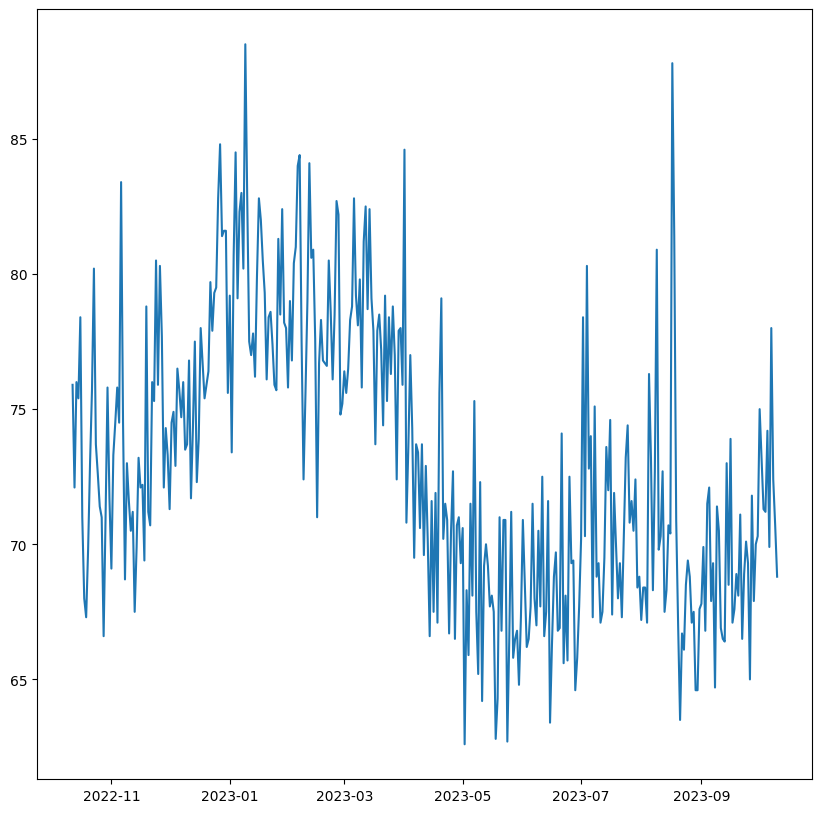

In [82]:
# View data plotted
plt.figure(figsize=(10,10))
plt.plot(dataset)
plt.savefig('Health Data', bbox_inches='tight', transparent=False)

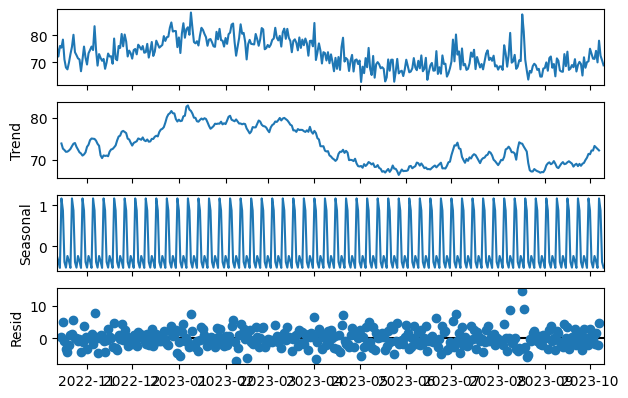

In [83]:
seas_d=sm.tsa.seasonal_decompose(dataset,model='add');
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

An initial look at the data shows some trends and seasonality, meaning the data in non-stationary.

I will experiment with different methods for making the data more stationary.
If the trends showed a different shape, I could potentially take the log at each step instead of the difference. Instead, I will try taking the seasonal difference, and if that doesn't work, taking the difference at each time step or even the second-order difference if necessary.

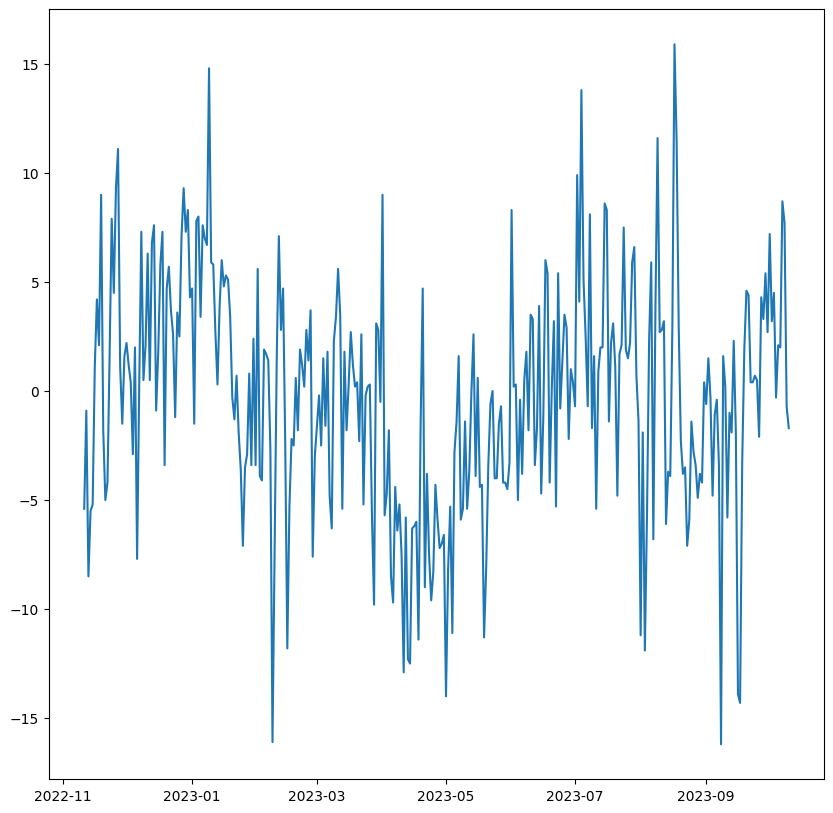

In [84]:
# Take the seasonal difference
seasonal_period = 30  # Monthly data within a year

# Calculate the seasonal difference
seasonal_diff = dataset['y'] - dataset['y'].shift(seasonal_period)

# Drop NaN values resulting from the shift
seasonal_diff = seasonal_diff.dropna()

# Check for stationarity in 'seasonal_diff' using appropriate tests and plots
plt.figure(figsize=(10, 10))
plt.plot(seasonal_diff)
plt.savefig('resting_bpm_seasonal_diff', bbox_inches='tight', transparent=False)

My data still doesn't look very stationary, so I will try differencing.

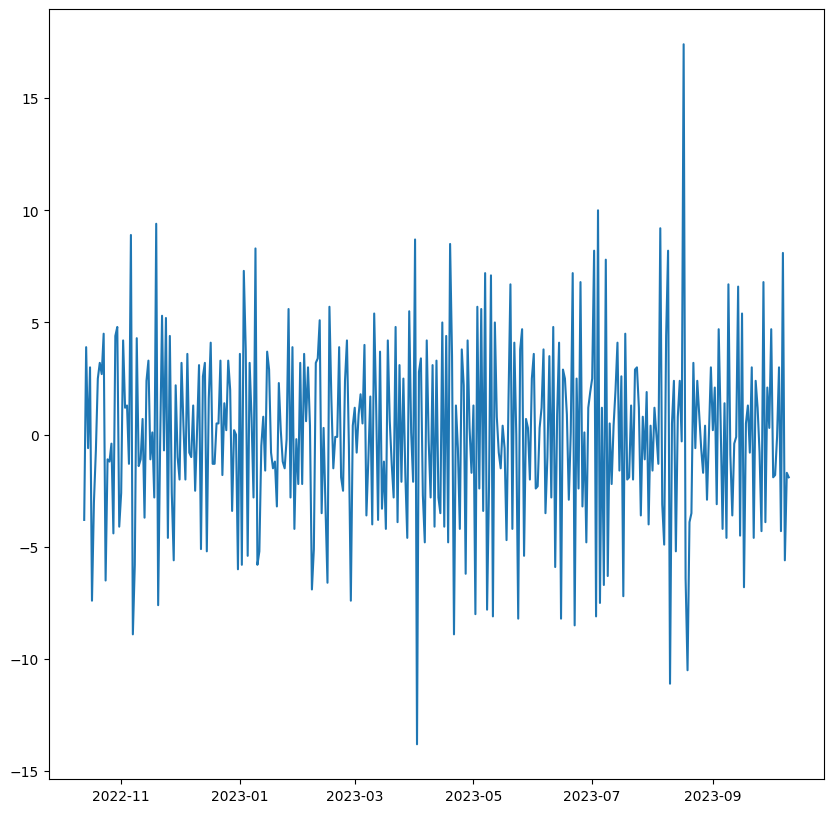

In [85]:
# Take the difference to make data more stationary
plt.figure(figsize=(10, 10))
plt.plot(dataset.diff())
plt.savefig('resting_bpm_diff', bbox_inches='tight', transparent=False)

In [86]:
# Take the diff and remove the first value
first_diff_dataset = dataset.diff()
first_diff_dataset = first_diff_dataset['2022-10-13':]
first_diff_dataset.head()

,y
ds,
2022-10-13,-3.8
2022-10-14,3.9
2022-10-15,-0.6
2022-10-16,3.0
2022-10-17,-7.4


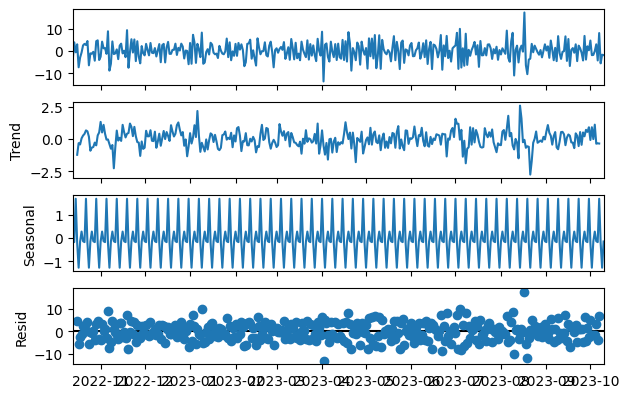

In [87]:
# Check for stationarity
seas_d=sm.tsa.seasonal_decompose(first_diff_dataset,model='add');
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

The data definitely looks more stationary but I think I can do better.

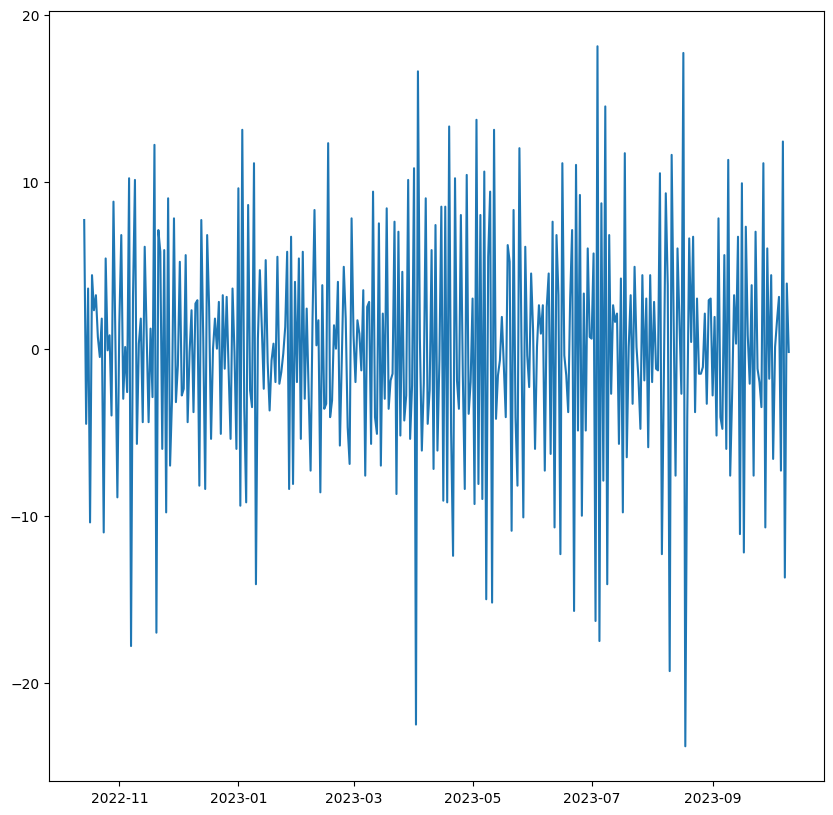

In [88]:
# Take the diff twice in a row - second order differencing (the difference of the difference)
plt.figure(figsize=(10, 10))
plt.plot(dataset.diff().diff())
plt.savefig('resting_bpm_2nd-order_diff', bbox_inches='tight', transparent=False)

In [89]:
# Take the second order difference
dataset_diff = dataset.diff().diff()

# Remove the first two NaN values
dataset_diff = dataset_diff.loc['2022-10-14':]

dataset_diff.head()

,y
ds,
2022-10-14,7.7
2022-10-15,-4.5
2022-10-16,3.6
2022-10-17,-10.4
2022-10-18,4.4


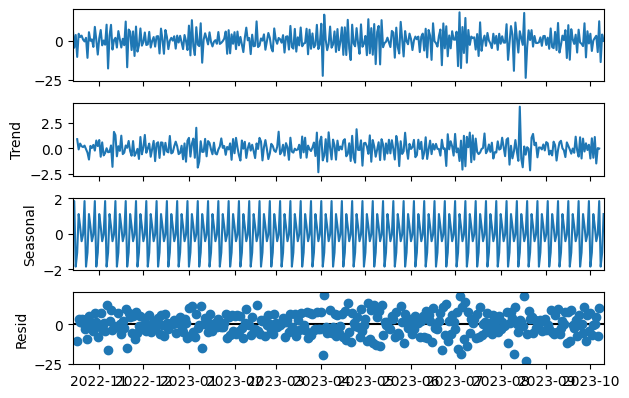

In [90]:
# Check for stationarity
seas_d=sm.tsa.seasonal_decompose(dataset_diff,model='add');
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

Second-order differencing seems to be the best level of differencing for removing the seasonality and trends in the dataset.

# Create Training and Test Sets

The data starts on 2022-10-14 and ends on 2023-10-10.
I will take all but the last month as the training data with a cutoff date of 2023-09-10

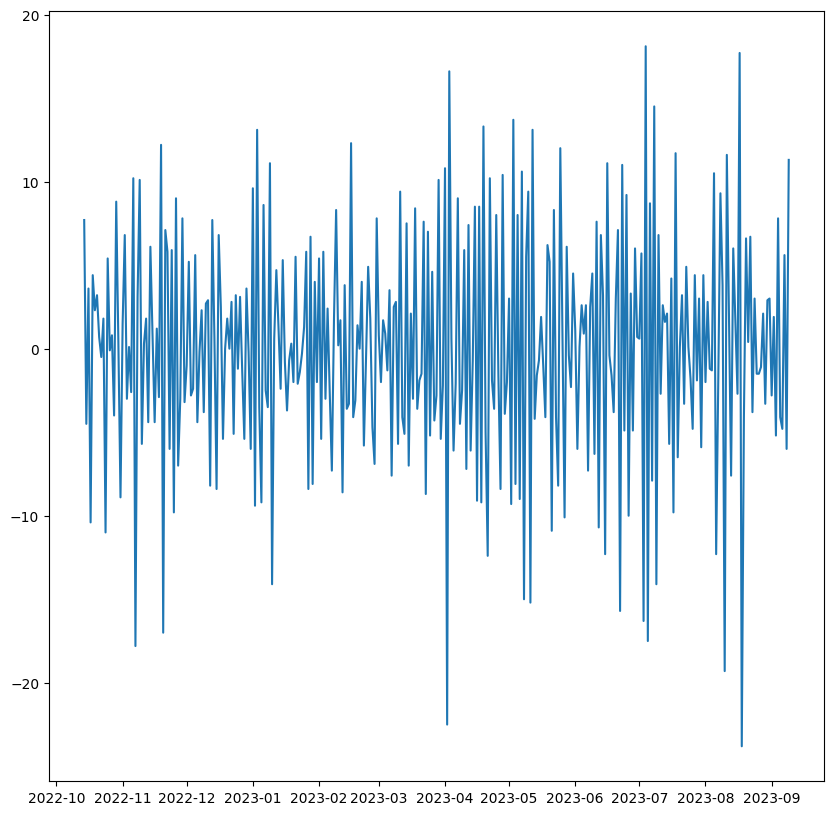

In [91]:
cutoff_date = '2023-09-10'

train = dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)]
test = dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)]

plt.figure(figsize=(10, 10))
plt.plot(train)
plt.savefig('training_set', bbox_inches='tight', transparent=False)

# SARIMAX
## Seasonal Autoregressive Integrated Moving Average with Exogenous regressors model
- order: tuple of values p, q, and d
- seasonal_order: tuple of values P, D, Q, S (s is the periodicity)
= s=7 would be once a week

In [92]:
# Create the SARIMAX model
model = SARIMAX(train, order=(2,1,3), seasonal_order=(0,0,0,7))

In [93]:
# fit the model (train it)
results = model.fit(disp=True)

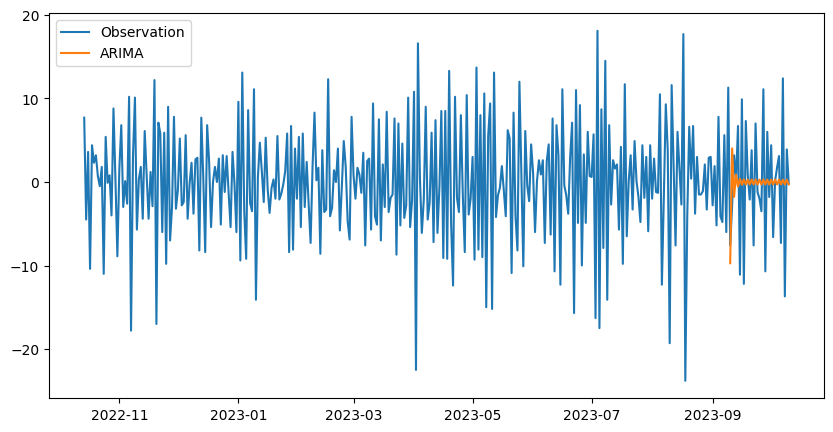

In [94]:
# predict a month after the cutoff date
sarimax_prediction = results.predict(
    start=cutoff_date, end='2023-10-10', dynamic=False)

plt.figure(figsize=(10,5))
# plot the original dataset
l1, = plt.plot(dataset_diff, label ='Observation')
# plot the predicted values
l2, = plt.plot(sarimax_prediction, label ='ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX_prediction', bbox_inches='tight', transparent=False)

In [95]:
# Get the mean absolute error to see how accurate the prediction was
# Result; 5.47 - that's really low!
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE =  5.478206581529032


In [96]:
# function to get best-performing parameter values automatically
model = pm.auto_arima(train, start_p=1, start_q=1,
                      m=7,
                      d=None,
                      season=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2220.033, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2061.291, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2218.040, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=2059.325, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=2061.290, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=2059.598, Time=3.42 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=1971.082, Time=0.18 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=1970.861, Time=0.27 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=1972.861, Time=0.85 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=1971.260, Time=1.46 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=1970.846, Time=0.53 sec
 ARIMA(2,0,0)(0,0,2)[7] intercept   : AIC=1972.828, Time=1.12 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=1

SARIMAX auto MAE =  5.478206581529032


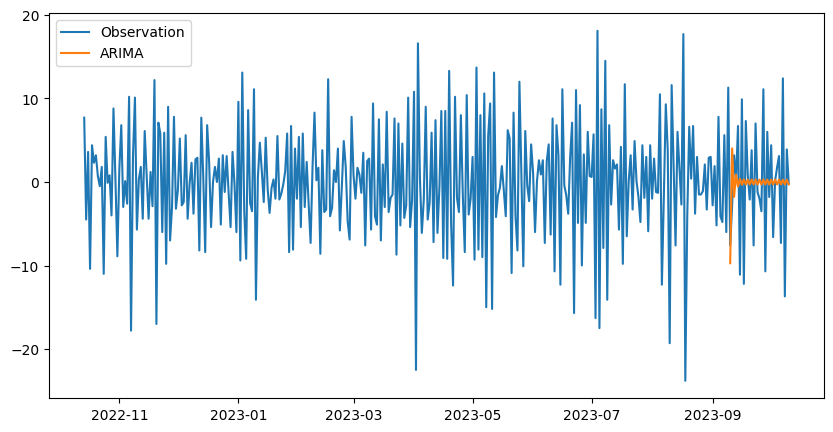

In [97]:
# Best model:  ARIMA(5,0,0)(1,0,1)[7]  (saved in model instance)
# Now we can predict using the best model
sarimax_prediction_automated = model.predict(n_periods=test.shape[0])
sarimax_prediction_automated = pd.DataFrame({'ds':test.index, 'y':sarimax_prediction})
sarimax_prediction_automated.set_index('ds', inplace=True)
plt.figure(figsize=(10,5))
l1, = plt.plot(dataset_diff, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX_prediction_automated', bbox_inches='tight', transparent=False)
print('SARIMAX auto MAE = ', mean_absolute_error(sarimax_prediction_automated, test))

### Explanation from Coursera:
"The diagnostic plots enable us to analyse the accuracy of our model, and whether there is any (residual) information in the data that should be used to improve the model.
The package provides four diagnostic plots. Below I only give a very brief description of these plots.
- Standardized residuals over time plot: Calculates the residue, or the difference between observed and predicted values, as a function of time.
- Histogram: It's the count of values against the computed residual. Note: that residual in the x-axis was the one in the y-axis in the plot above.
- Normal Q-Q: Typically, model errors should be normally distributed. This plot checks if this is the case; if the points are nearly linear, then the errors are normally distributed. Which is the case in our plot.
- Correlogram: Checks the autocorrelation in the data, to ensure that the data is random.
- *Randomness of data* is a necessary condition for the *validity* of the model, and it is checked by the correlogram.
- In the correlogram, the *autocorrelation* is plotted against *time lags*. If the values are close to zero, then this is an indication of the randomness of the data, as is the case in our plot above."

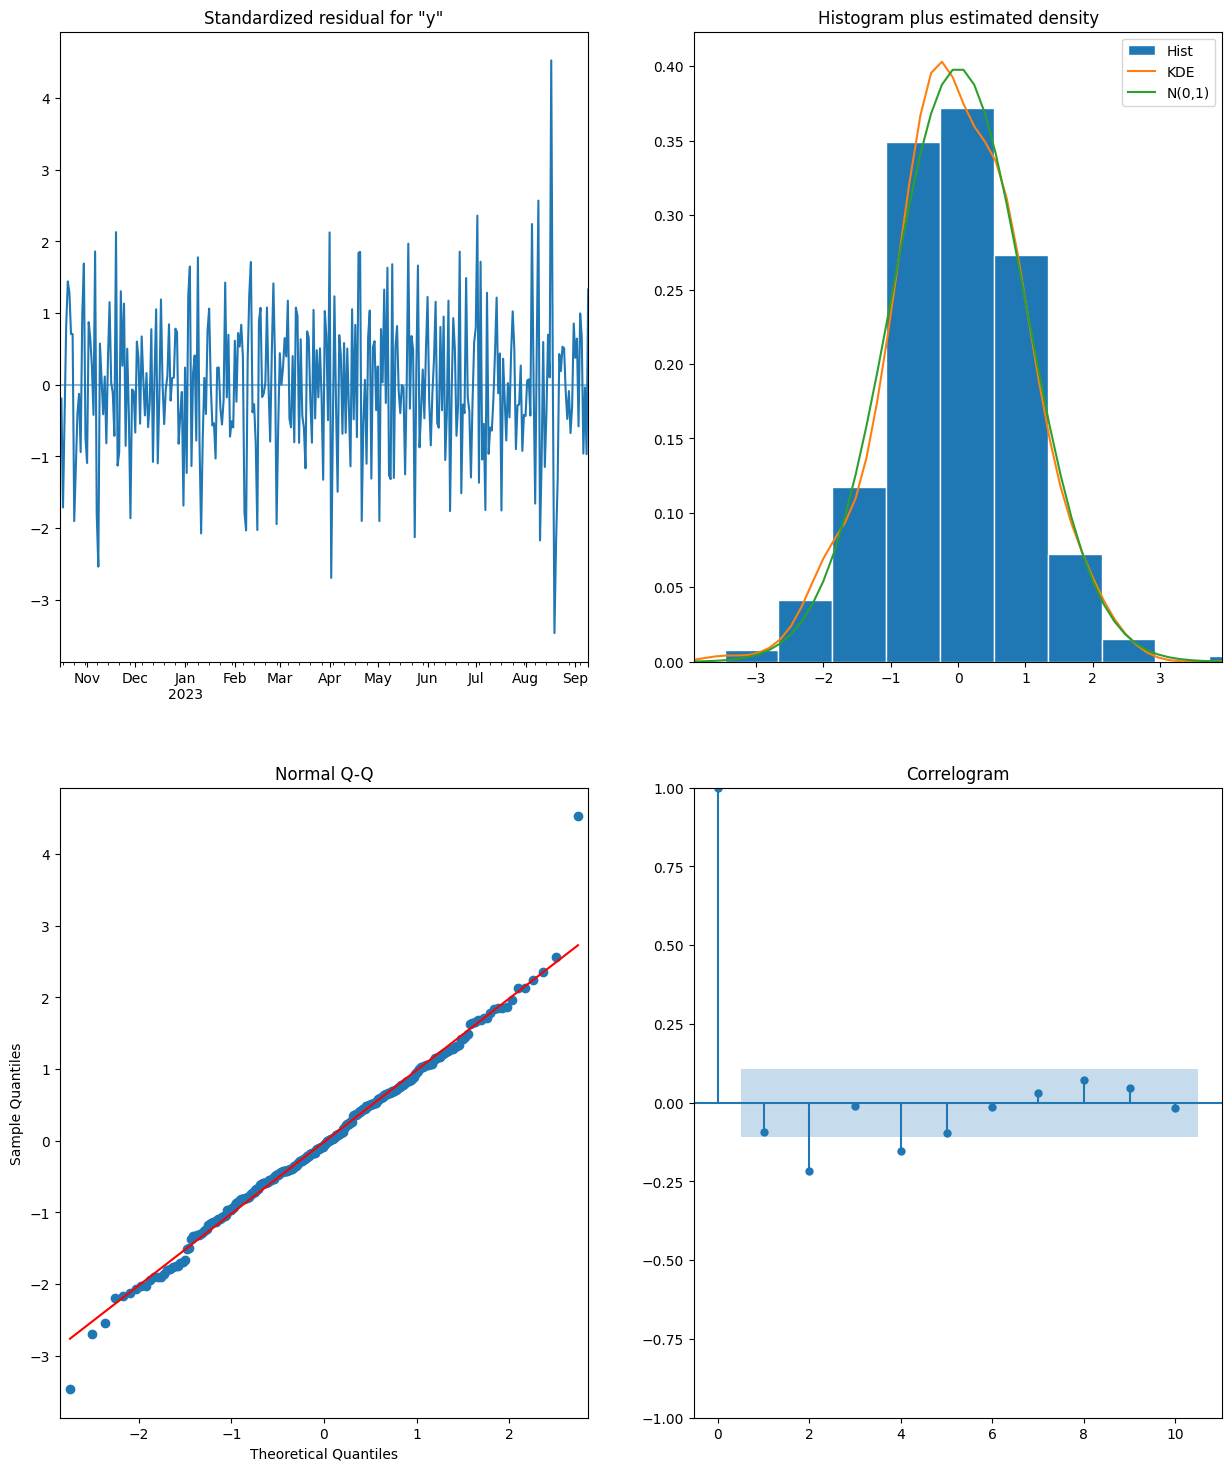

In [98]:
results.plot_diagnostics(figsize=(15,18))
plt.show()

# Facebook Prophet

In [99]:
# Gather the training data
train['ds'] = train.index.values

In [100]:
# create a Prophet object and call fit() to train the model
m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt_q1fhp/bw409ms8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt_q1fhp/yajrqmh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61505', 'data', 'file=/tmp/tmpxt_q1fhp/bw409ms8.json', 'init=/tmp/tmpxt_q1fhp/yajrqmh4.json', 'output', 'file=/tmp/tmpxt_q1fhp/prophet_modelb1qm7lrf/prophet_model-20231012174410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [101]:
# Make predictions on test set
future = m.make_future_dataframe(periods=test.shape[0])
prophet_prediction = m.predict(future)

In [102]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= cutoff_date]
print('Prophet MAE = ', mean_absolute_error(prophet_future, test))
# gives MAE of 5.44

Prophet MAE =  5.447092879659363


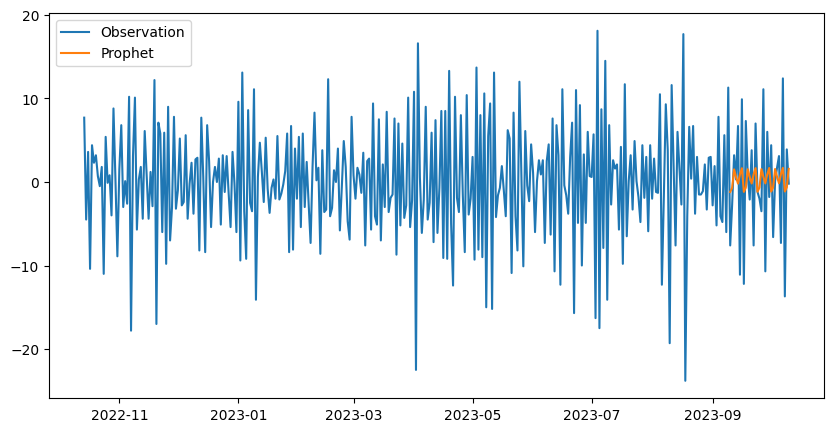

In [103]:
# Plot the results
plt.figure(figsize=(10,5))
l1, = plt.plot(dataset_diff, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1,l2])
plt.savefig('prophet predictions', bbox_inches='tight', transparent=False)

# XGBOOST and NN (Neural Networks)

In [104]:
# Extract more features
def featurize(t):
  X = pd.DataFrame()

  X['day'] = t.index.day
  X['month'] = t.index.month
  X['quarter'] = t.index.quarter
  X['year'] = t.index.year
  X['dayofweek'] = t.index.dayofweek
  X['dayofyear'] = t.index.dayofyear
  X['weekofyear'] = t.index.weekofyear
  y = t.y
  return X, y

featurize(dataset_diff)[0].head()

,day,month,quarter,year,dayofweek,dayofyear,weekofyear
0,14,10,4,2022,4,287,41
1,15,10,4,2022,5,288,41
2,16,10,4,2022,6,289,41
3,17,10,4,2022,0,290,42
4,18,10,4,2022,1,291,42


In [105]:
# Create training and test datasets
X_train, y_train = featurize(
    dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)])
X_test, y_test = featurize(
    dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)])

In [106]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [107]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

In [108]:
# Create XGBOOST model
XGBOOST_model = XGBRegressor(n_estimators=7)

In [109]:
# Train model
XGBOOST_model.fit(scaled_train, y_train,
                  eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                  verbose=True)

# Make prediction
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

[0]	validation_0-rmse:6.51085	validation_1-rmse:6.99174
[1]	validation_0-rmse:6.27539	validation_1-rmse:6.99325
[2]	validation_0-rmse:6.14729	validation_1-rmse:7.04220
[3]	validation_0-rmse:5.98530	validation_1-rmse:6.88748
[4]	validation_0-rmse:5.85217	validation_1-rmse:6.88659
[5]	validation_0-rmse:5.70494	validation_1-rmse:6.84127
[6]	validation_0-rmse:5.64474	validation_1-rmse:6.87345


In [110]:
# Get MAE - 5.61
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE =  5.61859993316353


In [111]:
# Create NN model
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))

# Train model
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=210, verbose=1)

# Get predictions
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/210
11/11 [==============================] - 1s 12ms/step - loss: 5.4596 - val_loss: 5.6034
Epoch 2/210
11/11 [==============================] - 0s 3ms/step - loss: 5.4375 - val_loss: 5.5913
Epoch 3/210
11/11 [==============================] - 0s 3ms/step - loss: 5.4255 - val_loss: 5.5982
Epoch 4/210
11/11 [==============================] - 0s 5ms/step - loss: 5.4182 - val_loss: 5.5951
Epoch 5/210
11/11 [==============================] - 0s 3ms/step - loss: 5.4149 - val_loss: 5.5952
Epoch 6/210
11/11 [==============================] - 0s 4ms/step - loss: 5.4148 - val_loss: 5.5902
Epoch 7/210
11/11 [==============================] - 0s 5ms/step - loss: 5.4104 - val_loss: 5.5819
Epoch 8/210
11/11 [==============================] - 0s 5ms/step - loss: 5.4076 - val_loss: 5.5771
Epoch 9/210
11/11 [==============================] - 0s 3ms/step - loss: 5.4042 - val_loss: 5.5723
Epoch 10/210
11/11 [==============================] - 0s 3ms/step - loss: 5.4014 - val_loss: 5.5690
Epoch 11

In [112]:
# Get the MAE - 5.50
print('NN MAE = ', mean_absolute_error(NN_prediction, test))

NN MAE =  5.510613849951373


# Compare all 4 models
- SARIMAX
- Fb Prophet
- XGBOOST
- NN

In [113]:
# The lower the MAE, the better - Fb Prophet is the winner for this one.
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))
print('Prophet MAE = ', mean_absolute_error(prophet_future, test))
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))
print('NN MAE = ', mean_absolute_error(NN_prediction, test))

XGBOOST MAE =  5.61859993316353
Prophet MAE =  5.447092879659363
SARIMAX MAE =  5.478206581529032
NN MAE =  5.510613849951373


<Figure size 2000x2000 with 0 Axes>

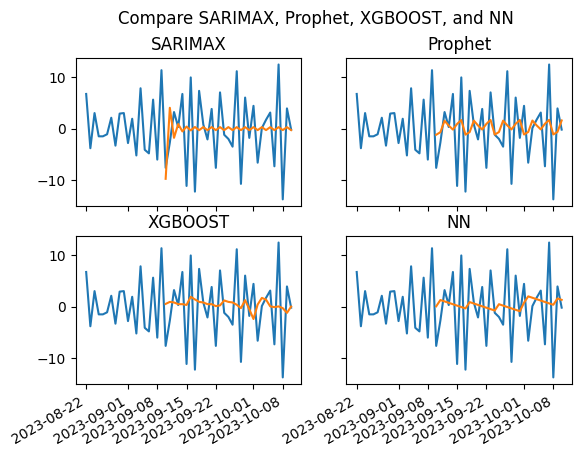

In [114]:
# Visualize performance on test set
XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20,20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, Prophet, XGBOOST, and NN')
axs[0, 0].plot(dataset_diff.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset_diff.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset_diff.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset_diff.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
  ax.label_outer()
fig.autofmt_xdate()

fig.savefig('comparison',
            bbox_inches='tight', transparent=False)

# Make Future Predictions
Based on this past year's recordings of my resting heart rate, what could the next 31 days look like?

In [127]:
# sarimax
sarimax_future_prediction = results.predict(start='2023-10-11', end='2023-11-10')

# fb prophet
future = m.make_future_dataframe(periods=test.shape[0] + 31)
prophet_future_prediction = m.predict(future)
prophet_future_prediction = prophet_future_prediction.set_index('ds')

In [128]:
# for XGboost and NN we to generate the X dataset.

def featurize_dates(t):
  X = pd.DataFrame()

  X['day'] = t.index.day
  X['month'] = t.index.month
  X['quarter'] = t.index.quarter
  X['year'] = t.index.year
  X['dayofweek'] = t.index.dayofweek
  X['dayofyear'] = t.index.dayofyear
  X['weekofyear'] = t.index.weekofyear
  return X



In [129]:
# Apply it on the future DataFrame we got from fbprophet
# to generate forecasts using the trained XGBOOST model

future= future.set_index('ds')
X_future = featurize_dates(future)
scaled_future = scaler.transform(X_future)
XGBOOST_future = XGBOOST_model.predict(scaled_future)

In [130]:
NN_future = NN_model.predict(scaled_future)

13/13 [==============================] - 0s 959us/step


<Figure size 2000x2000 with 0 Axes>

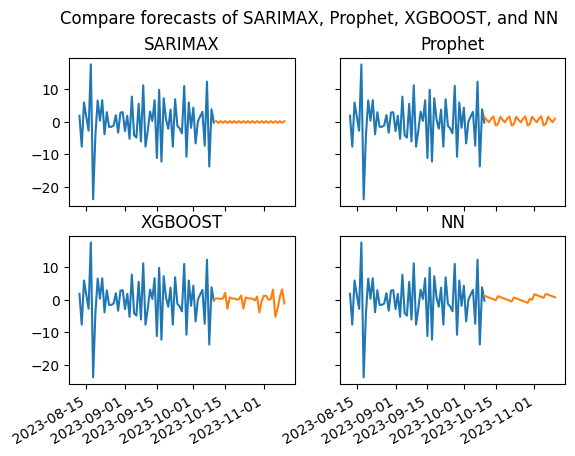

In [132]:
# Plot the entire time series including training, test, and future predictions

XGBOOST_df = pd.DataFrame({'y': XGBOOST_future.tolist()})
XGBOOST_df.index = future.index

future_prediction_count = 31 + test.shape[0]

NN_df = pd.DataFrame(NN_future)
NN_df.index = future.index
plt.figure(figsize=(20,20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare forecasts of SARIMAX, Prophet, XGBOOST, and NN')
axs[0, 0].plot(dataset_diff.tail(60))
axs[0, 0].plot(sarimax_future_prediction.tail(32))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset_diff.tail(60))
axs[0, 1].plot(prophet_future_prediction['yhat'].tail(32))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset_diff.tail(60))
axs[1, 0].plot(XGBOOST_df.tail(32))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset_diff.tail(60))
axs[1, 1].plot(NN_df.tail(32))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
  ax.label_outer()
fig.autofmt_xdate()

plt.savefig('comparison_forecasts',
            bbox_inches='tight', transparent=False)

# View results in tables
To convert the predicted values back into real BPM numbers, I will need to reverse the second-order differencing. I will do this by taking the cumulative sum of the predicted values (reversing the second order difference) thereby creating first-order differenced values. I will then take the last value of the original dataset and add the first-order differenced values to create realistic predicted bpm numbers.

In [120]:
prophet_future_prediction.head()
# The column I want is 'yhat'

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2022-10-14,-0.331798,-8.505286,8.949164,-0.331798,-0.331798,0.528913,0.528913,0.528913,0.528913,0.528913,0.528913,0.0,0.0,0.0,0.197115
2022-10-15,-0.329698,-8.082175,9.938614,-0.329698,-0.329698,1.276790,1.276790,1.276790,1.276790,1.276790,1.276790,0.0,0.0,0.0,0.947092
2022-10-16,-0.327598,-10.659780,6.480739,-0.327598,-0.327598,-1.553909,-1.553909,-1.553909,-1.553909,-1.553909,-1.553909,0.0,0.0,0.0,-1.881507
2022-10-17,-0.325497,-9.712575,7.535227,-0.325497,-0.325497,-1.060289,-1.060289,-1.060289,-1.060289,-1.060289,-1.060289,0.0,0.0,0.0,-1.385787
2022-10-18,-0.323397,-8.198731,10.365865,-0.323397,-0.323397,1.150300,1.150300,1.150300,1.150300,1.150300,1.150300,0.0,0.0,0.0,0.826903


In [121]:
# Last value from the original dataset
initial_bpm = dataset['y'].iloc[-1]
dataset.tail()

,y
ds,
2023-10-06,69.9
2023-10-07,78.0
2023-10-08,72.4
2023-10-09,70.7
2023-10-10,68.8


In [122]:
# Get the last BPM value in the original dataset - 68.8
initial_bpm = dataset['y'].iloc[-1]

# Inverse the second-order difference predictions
predictions = prophet_future_prediction['yhat'].tail(31).cumsum()

# Add the last value to obtain realistic BPM values
realistic_bpm_values = predictions + initial_bpm

realistic_bpm_values.tail(31)

ds
2023-10-10    70.370136
2023-10-11    71.014742
2023-10-12    70.874233
2023-10-13    71.829212
2023-10-14    73.534145
2023-10-15    72.410455
2023-10-16    71.782461
2023-10-17    73.367133
2023-10-18    74.026275
2023-10-19    73.900302
2023-10-20    74.869818
2023-10-21    76.589286
2023-10-22    75.480132
2023-10-23    74.866675
2023-10-24    76.465883
2023-10-25    77.139560
2023-10-26    77.028124
2023-10-27    78.012176
2023-10-28    79.746180
2023-10-29    78.651562
2023-10-30    78.052641
2023-10-31    79.666386
2023-11-01    80.354599
2023-11-02    80.257699
2023-11-03    81.256286
2023-11-04    83.004827
2023-11-05    81.924745
2023-11-06    81.340360
2023-11-07    82.968641
2023-11-08    83.671390
2023-11-09    83.589026
Name: yhat, dtype: float64

# Summary
Fb Prophet predicts that my resting BPM values will slowly increase over the next 31 days.

For future research, I think it would be fun to examine how my 'Steps' and 'Time Asleep' may be associated with resting BPM.